# Figure4

In [1]:
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

In [2]:
%run 00_data_preprocessing.ipynb

In [3]:
dir_path = '../../results/main/04'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [4]:
def set_scientific_yticks(ax):
    """Force y-axis to show scientific notation in 10^x format"""
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

In [5]:
def set_scientific_xticks(ay):
    """Force y-axis to show scientific notation in 10^x format"""
    ay.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ay.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

# Function

In [6]:
t_start = 2  # Delay (in days) before CTLs infiltrate the tumor after injection

def ctl_pulse(t, dose_list, dose_days, delta_t):
    """Return the CTL input function F(t), based on dose schedule and delivery window."""
    total = 0
    for dose, day in zip(dose_list, dose_days):
        if day + t_start <= t < day + t_start + delta_t:
            total += dose / delta_t
    return total

In [7]:
# Model: Saturable Suppression by MDSCs
def model(y, t, dose_list, dose_days, delta_t, params):
    k_s, e_p, d_e, d_d, d_s, d_m, m_f, k_m = params
    V, E, D, S, M = y
    F_t = ctl_pulse(t, dose_list, dose_days, delta_t)

    # ===ODE Model===
    dVdt = v_r * V * np.log(v_k / V) - k_s * S * V
    dEdt = F_t + e_p * E * V**2 / (V**2 + k_v)  - d_m * E * M /(k_m+M) - d_e * E
    dDdt = d_m * E * M /(k_m+M) + d_e * E - d_d * D
    dSdt = E - d_s * S
    dMdt = m_f * F_t + m_v * V - m_d * M

    return [dVdt, dEdt, dDdt, dSdt, dMdt]

In [8]:
param = np.array([
    1.3104e-07, 1.8338e+00, 1.9608e+00, 6.3755e-01,
    9.9399e-01, 8.9600e-01, 4.7826e+00, 3.1554e+07
])

# ==Fixed param ==
v_r = 9.99e-2
v_k = 1.64e+10
m_v = 4.87e-2
m_d = 3.06e-1

# Other article param
k_v = 2.02e7

delta_t = 1

# Simulation

In [9]:
t_eval = np.arange(-1, 20.01, 0.01)
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]

reference_time = t_start + delta_t  # 2 + 1 = 3 days
sol_base = odeint(model, y0, t_eval, args=([0], [0], delta_t, param))
V_ref = np.interp(reference_time, t_eval, sol_base[:, 0])

In [10]:
t_eval_long = np.arange(-1, 20.01, 0.01)
target_day = 20
reference_day = 3

# Reference simulation (1-shot)
dose_1shot = [0]
days_1shot = [0]
sol_ref = odeint(model, y0, t_eval_long, args=(dose_1shot, days_1shot, delta_t, param), hmax=0.01)
#V_target = sol_ref[np.where(np.abs(t_eval_long - reference_day) < 1e-5)[0][0], 0]
V_target = V_ref

# Dose days
days_7 = list(range(0, 8))
days_20 = list(range(0, 20))

# Minimization search
def find_min_ctl_total(dose_days, V_target, max_dose=1e8):
    for total_dose in np.arange(1e7, max_dose + 1e6, 2e6):
        daily_dose = total_dose / len(dose_days)
        dose_list = [daily_dose] * len(dose_days)
        sol = odeint(model, y0, t_eval_long, args=(dose_list, dose_days, delta_t, param), hmax=0.01)
        V_end = sol[np.where(np.abs(t_eval_long - target_day) < 1e-5)[0][0], 0]
        if V_end <= V_target:
            return total_dose, V_end
    return None, None

# Run searches
min_ctl_7, final_V_7 = find_min_ctl_total(days_7, V_target)
min_ctl_20, final_V_20 = find_min_ctl_total(days_20, V_target)

min_ctl_7, final_V_7, min_ctl_20, final_V_20, V_target

(68000000.0,
 202374117.65484408,
 52000000.0,
 191155750.62944,
 211668212.24340189)

In [11]:
44000000/20, 42000000/20

(2200000.0, 2100000.0)

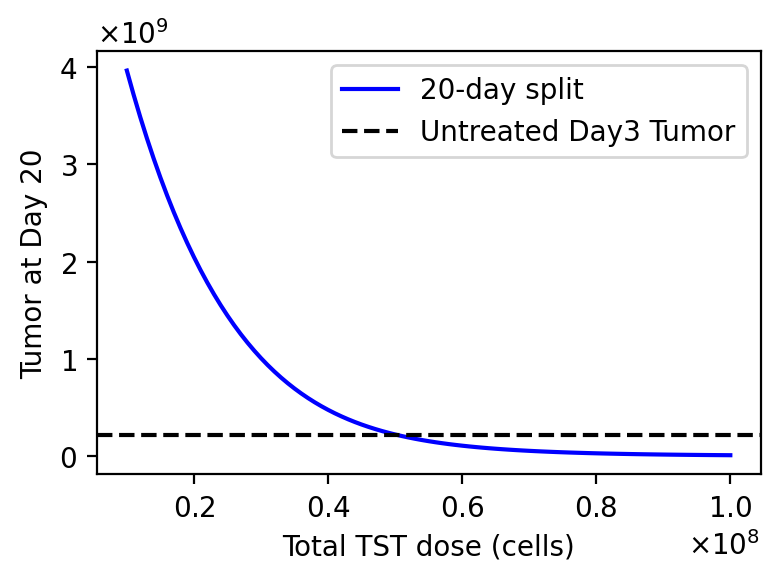

In [12]:
dose_range = np.arange(1e7, 1.0e8 + 1e6, 1e6)
V_end_list_20 = []

for total_dose in dose_range:
    dose_20 = [total_dose / len(days_20)] * len(days_20)
    sol_20 = odeint(model, y0, t_eval_long, args=(dose_20, days_20, delta_t, param), hmax=0.01)
    V_end_20 = sol_20[np.where(np.abs(t_eval_long - target_day) < 1e-5)[0][0], 0]
    V_end_list_20.append(V_end_20)

plt.figure(figsize=(4, 3), dpi=200)
plt.plot(dose_range, V_end_list_20, label="20-day split", color='blue')
plt.axhline(V_target, linestyle="--", color="black", label="Untreated Day3 Tumor")
plt.xlabel("Total TST dose (cells)")
plt.ylabel("Tumor at Day 20")
#plt.title("Dose-response curve")
plt.legend()
#plt.yscale('log')
#plt.grid(True)
plt.tight_layout()
ax = plt.gca()
set_scientific_yticks(ax)
ay = plt.gca()
set_scientific_xticks(ay)

In [13]:
min_ctl_20, min_ctl_20/20

(52000000.0, 2600000.0)

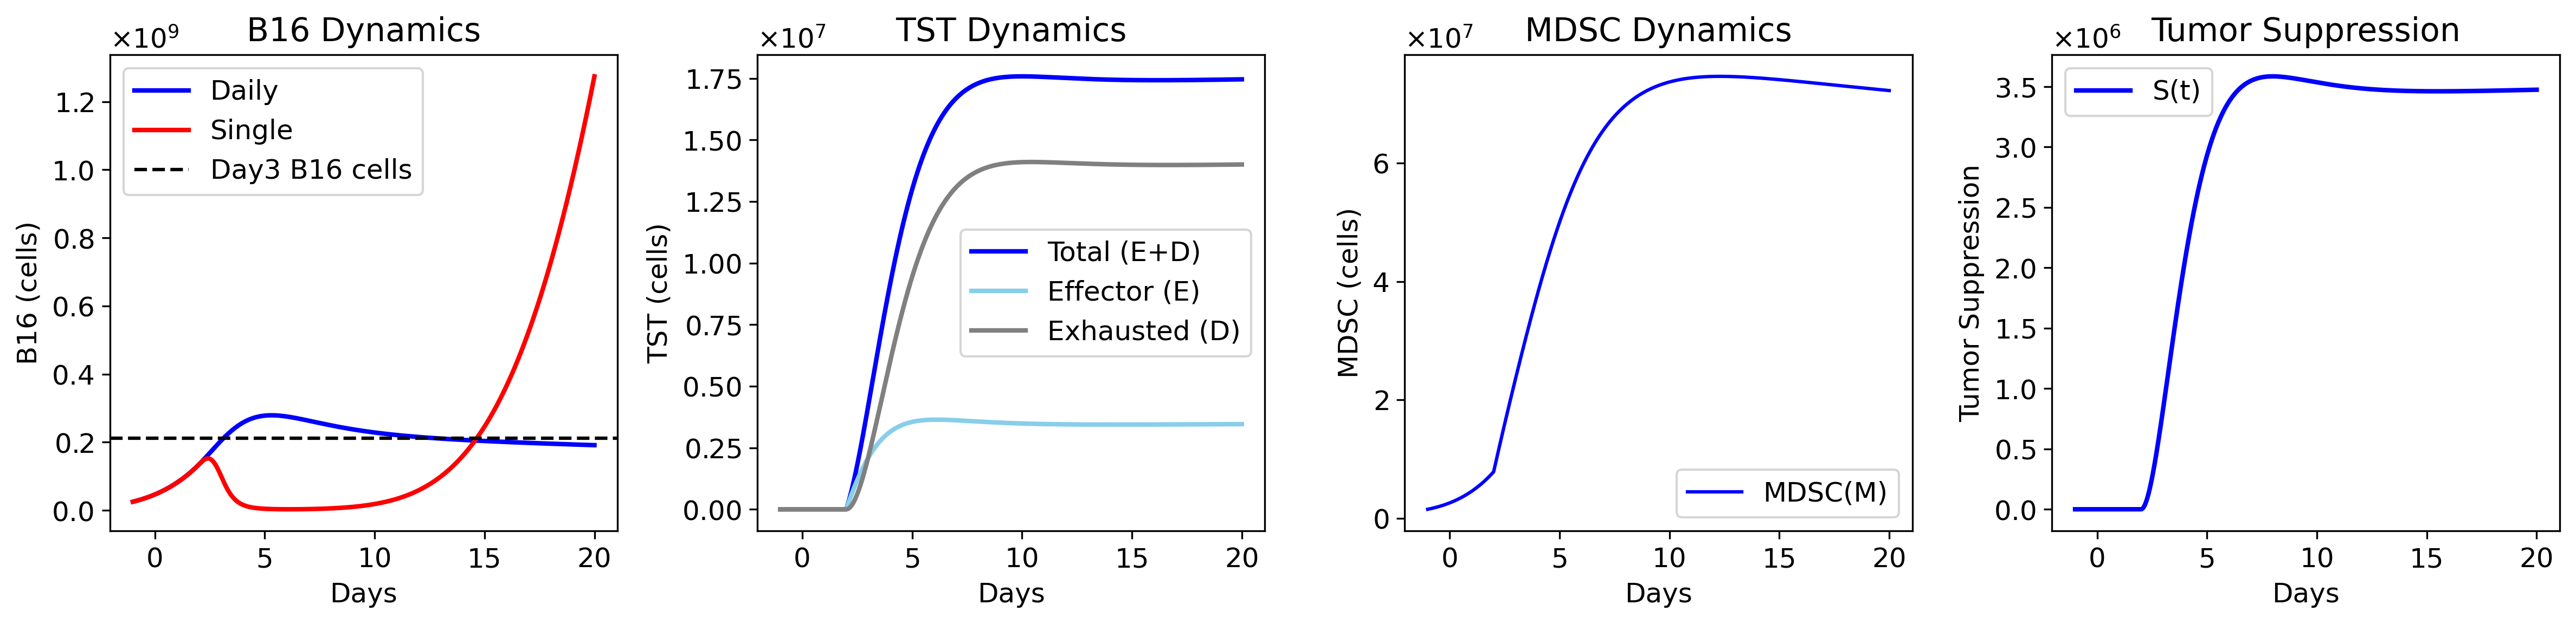

In [14]:
# === Initial Conditions and Time Axis ===
# V: tumor volume, E: effector CTLs, D: exhausted CTLs, S: suppression effect
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]  # y = [V, E, D, S, M]
# Time axis for simulation
t_eval = np.arange(-1, 20.01, 0.01)

# === Single Dose Condition ===
# CTL dosing schedule
dose_list = [min_ctl_20]   # total dose amount
dose_days = [0]            # day of administration
delta_t = 1                # duration of administration (in days)
sol2 = odeint(model, y0, t_eval, 
              args=(dose_list, dose_days, delta_t, param),
              hmax=0.001)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2 + D_sol2  # total CTLs = effector + exhausted

# === Fractionated Dosing Condition ===
dose_list = [min_ctl_20/20]*20  # equal fraction of total dose
dose_days = list(range(0, 20))  # daily administration for 20 days
delta_t = 1                     # duration of administration (in days)
sol = odeint(model, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param),
             hmax=0.01)
V_sol, E_sol, D_sol, S_sol, M_sol = sol.T
T_sol = E_sol + D_sol

# === Plotting ===
plt.figure(figsize=(16, 4), dpi=300)
plt.rcParams["font.size"] = 12
# --- Panel A: Tumor volume ---
plt.subplot(1, 4, 1)
plt.plot(t_eval, V_sol, label='Daily', color='blue', linewidth=2)
plt.plot(t_eval, V_sol2, label='Single', color='red', linewidth=2)
plt.axhline(V_ref, color='black', linestyle='--', label='Day3 B16 cells')
plt.xlabel("Days")
plt.ylabel("B16 (cells)")
plt.title("B16 Dynamics")
plt.legend()
ax = plt.gca()
set_scientific_yticks(ax)

# --- Panel B: CTL dynamics ---
plt.subplot(1, 4, 2)
plt.plot(t_eval, T_sol, label='Total (E+D)', color='blue', linewidth=2)
plt.plot(t_eval, E_sol, label='Effector (E)', color='skyblue', linewidth=2)
plt.plot(t_eval, D_sol, label='Exhausted (D)', color='gray', linewidth=2)
plt.xlabel('Days')
plt.ylabel('TST (cells)')
plt.title('TST Dynamics')
plt.legend()
ax = plt.gca()
set_scientific_yticks(ax)

# --- Panel C: MDSC ---
plt.subplot(1, 4, 3)
plt.plot(t_eval, M_sol, label='MDSC(M)', color='blue')
plt.xlabel('Days')
plt.ylabel("MDSC (cells)")
plt.title("MDSC Dynamics")
plt.legend()
ax = plt.gca()
set_scientific_yticks(ax)

# --- Panel C: Suppression Effect ---
plt.subplot(1, 4, 4)
plt.plot(t_eval, S_sol, label='S(t)', color='blue', linewidth=2)
plt.xlabel('Days')
plt.ylabel('Tumor Suppression')
plt.title('Tumor Suppression')
plt.legend()

plt.tight_layout()
ax = plt.gca()
set_scientific_yticks(ax)

# Daily

In [15]:
# TST pulse function
def ctl_pulse_strategy(t, schedule, delta_t, t_start=2):
    total = 0
    for dose, day in schedule:
        if day + t_start <= t < day + t_start + delta_t:
            total += dose / delta_t
    return total

# ODE with arbitrary schedule
def ode_with_schedule(y, t, schedule, delta_t, params):
    k_s, e_p, d_e, d_d, d_s, d_m, m_f, k_m = params
    V, E, D, S, M = y
    F_t = ctl_pulse_strategy(t, schedule, delta_t, t_start=t_start)
    # ===ODE Model===
    dVdt = v_r * V * np.log(v_k / V) - k_s * S * V
    dEdt = F_t + e_p * E * V**2 / (V**2 + k_v) - d_m * E * M /(k_m+M) - d_e * E
    dDdt = d_m * E * M /(k_m+M) + d_e * E - d_d * D
    dSdt = E - d_s * S
    dMdt = m_f * F_t + m_v * V - m_d * M

    return [dVdt, dEdt, dDdt, dSdt, dMdt]

In [16]:
# Return the nearest value from D_list
def round_to_D_list_new(value, D_list):
    return D_list[np.argmin(np.abs(D_list - value))]

# Schedule generator for each dosing strategy (based on maxD)
def generate_schedule_maxD(strategy, maxD, D_list):
    schedule = []
    V_prev = y0[0]
    D = maxD  # Initial dose
    for day in days:
        if strategy == "Daily":
            D_t = maxD 
        elif strategy == "Adaptive": # If tumor grew, increase dose (up to maxD); else, reduce
            if day == 0:
                D_t = maxD 
            else: 
                if V_hist[-1] > V_hist[-2]:
                    D = min(2 * D, maxD )
                else:
                    D = max(D / 2, 0)
                D_t = round_to_D_list_new(D, D_list)
        elif strategy == "OnOff": # On if tumor grew; off if not
            if day == 0:
                D_t = maxD 
            else:
                D_t = maxD  if V_hist[-1] > V_hist[-2] else 0
        else:
            raise ValueError("Unknown strategy")

        schedule.append((D_t, day))

        # Temporarily solve the ODE to update tumor volume (1-day forward)
        sol = odeint(ode_with_schedule, y0, t_eval[t_eval <= day + t_start + 1], 
                     args=(schedule, delta_t, param), hmax=0.01)
        V_hist = sol[:, 0][-2:]   # Tumor volume from previous and current day

    return schedule

In [17]:
daily_20 = min_ctl_20/20
daily_20

2600000.0

In [18]:
#days = list(range(0, 8))  # Day0 to Day20
days = list(range(0, 20))
t_eval = np.arange(-1, 20.01, 0.01)
D_list2 = np.array([0, daily_20/4, daily_20/2, daily_20])
maxD = max(D_list2)

strategies = ["Daily", "Adaptive", "OnOff"]
results = {}

for strategy in strategies:
    sched = generate_schedule_maxD(strategy, maxD, D_list2)
    sol = odeint(ode_with_schedule, y0, t_eval, args=(sched, delta_t, param), hmax=0.01)
    V_day20 = sol[np.where(np.abs(t_eval - 20) < 1e-5)[0][0], 0]
    total_ctl = sum(d for d, _ in sched)
    results[strategy] = {"V20": V_day20, "CTL_total": total_ctl, "solution": sol, "schedule": sched}

results

{'Daily': {'V20': 191155750.62944,
  'CTL_total': 52000000.0,
  'solution': array([[2.49823529e+07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.52749483e+06],
         [2.51446927e+07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.53501512e+06],
         [2.53079236e+07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.54259158e+06],
         ...,
         [1.91196218e+08, 3.45796873e+06, 1.40011334e+07, 3.47464344e+06,
          7.22463028e+07],
         [1.91175978e+08, 3.45801228e+06, 1.40012379e+07, 3.47468553e+06,
          7.22426898e+07],
         [1.91155751e+08, 3.45805583e+06, 1.40013425e+07, 3.47472763e+06,
          7.22390781e+07]]),
  'schedule': [(2600000.0, 0),
   (2600000.0, 1),
   (2600000.0, 2),
   (2600000.0, 3),
   (2600000.0, 4),
   (2600000.0, 5),
   (2600000.0, 6),
   (2600000.0, 7),
   (2600000.0, 8),
   (2600000.0, 9),
   (2600000.0, 10),
   (2600000.0, 11),
   (2600000.0, 12),
   (2600000.0, 13),
   (2600000.0, 14),
  

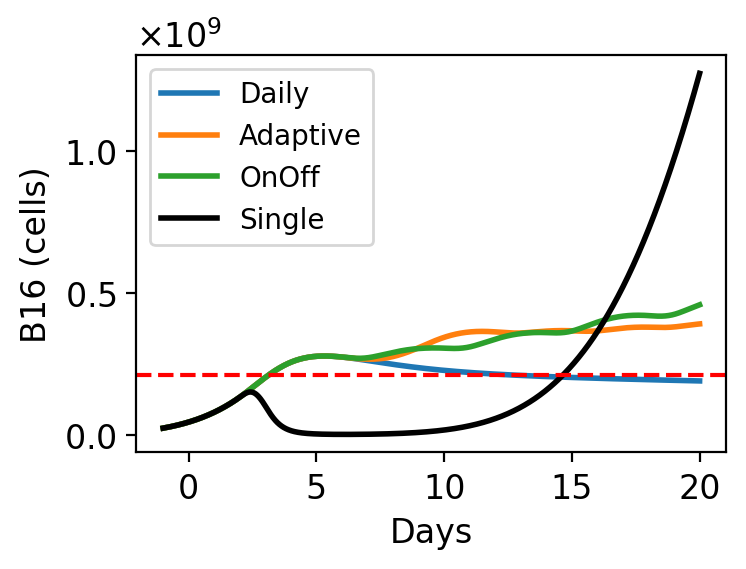

In [19]:
# === Comparison with Single-Dose Strategy ===
plt.rcParams.update({'font.size': 12})

# Initial conditions: 
# V = tumor volume, E = effector CTLs, D = exhausted CTLs, S = suppression signal
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]  # y = [V, E, D, S, M]

# Time axis for simulation
t_eval = np.arange(-1, 20.01, 0.01)

# CTL dosing schedule for single high-dose administration
dose_list = [daily_20 * 20]  # total dose as a single pulse
dose_days = [0]              # administration on day 0
delta_t = 1                  # duration of administration (in days)

# Solve ODE
sol2 = odeint(model, y0, t_eval, 
              args=(dose_list, dose_days, delta_t, param),
              hmax=0.001)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2 + D_sol2  # total CTLs

# === Time-Course Plot of Tumor Volume ===
plt.figure(figsize=(4, 3), dpi=200)

for strategy, data in results.items():
    V_sol = data["solution"][:, 0]
    plt.plot(t_eval, V_sol, label=strategy, linewidth=2)

# Plot single-dose result for comparison
plt.plot(t_eval, V_sol2, label='Single', linewidth=2, color='black')

# Reference line (e.g., Day 3 tumor size)
plt.axhline(V_ref, color='red', linestyle='--')

plt.xlabel("Days")
plt.ylabel("B16 (cells)")
#plt.title("Comparison of Dosing Strategies")
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()

ax = plt.gca()
set_scientific_yticks(ax)


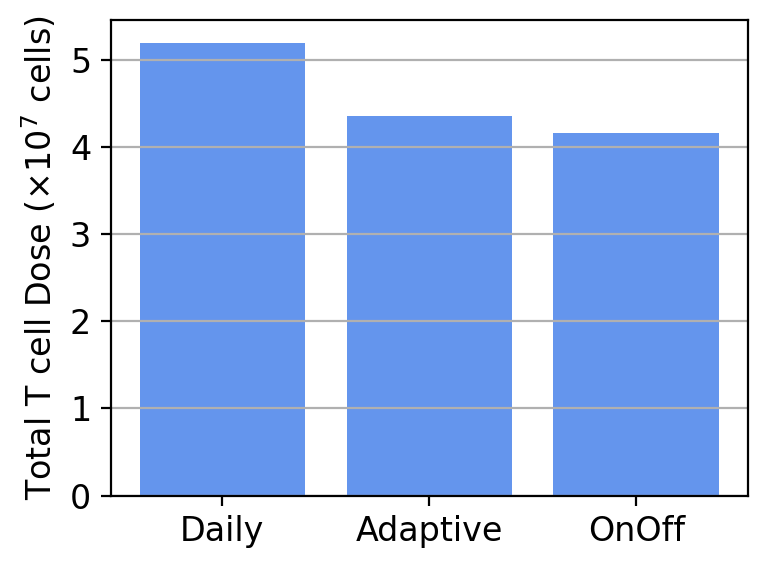

In [20]:
# Visualize total CTL dose for each strategy as a bar graph
strategies = list(results.keys())
# Convert units to 10^7 cells for readability
total_doses = [results[strategy]["CTL_total"] / 1e7 for strategy in strategies]

plt.figure(figsize=(4, 3), dpi=200)
bars = plt.bar(strategies, total_doses, color='cornflowerblue')
plt.ylabel(r"Total T cell Dose ($\times 10^7$ cells)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

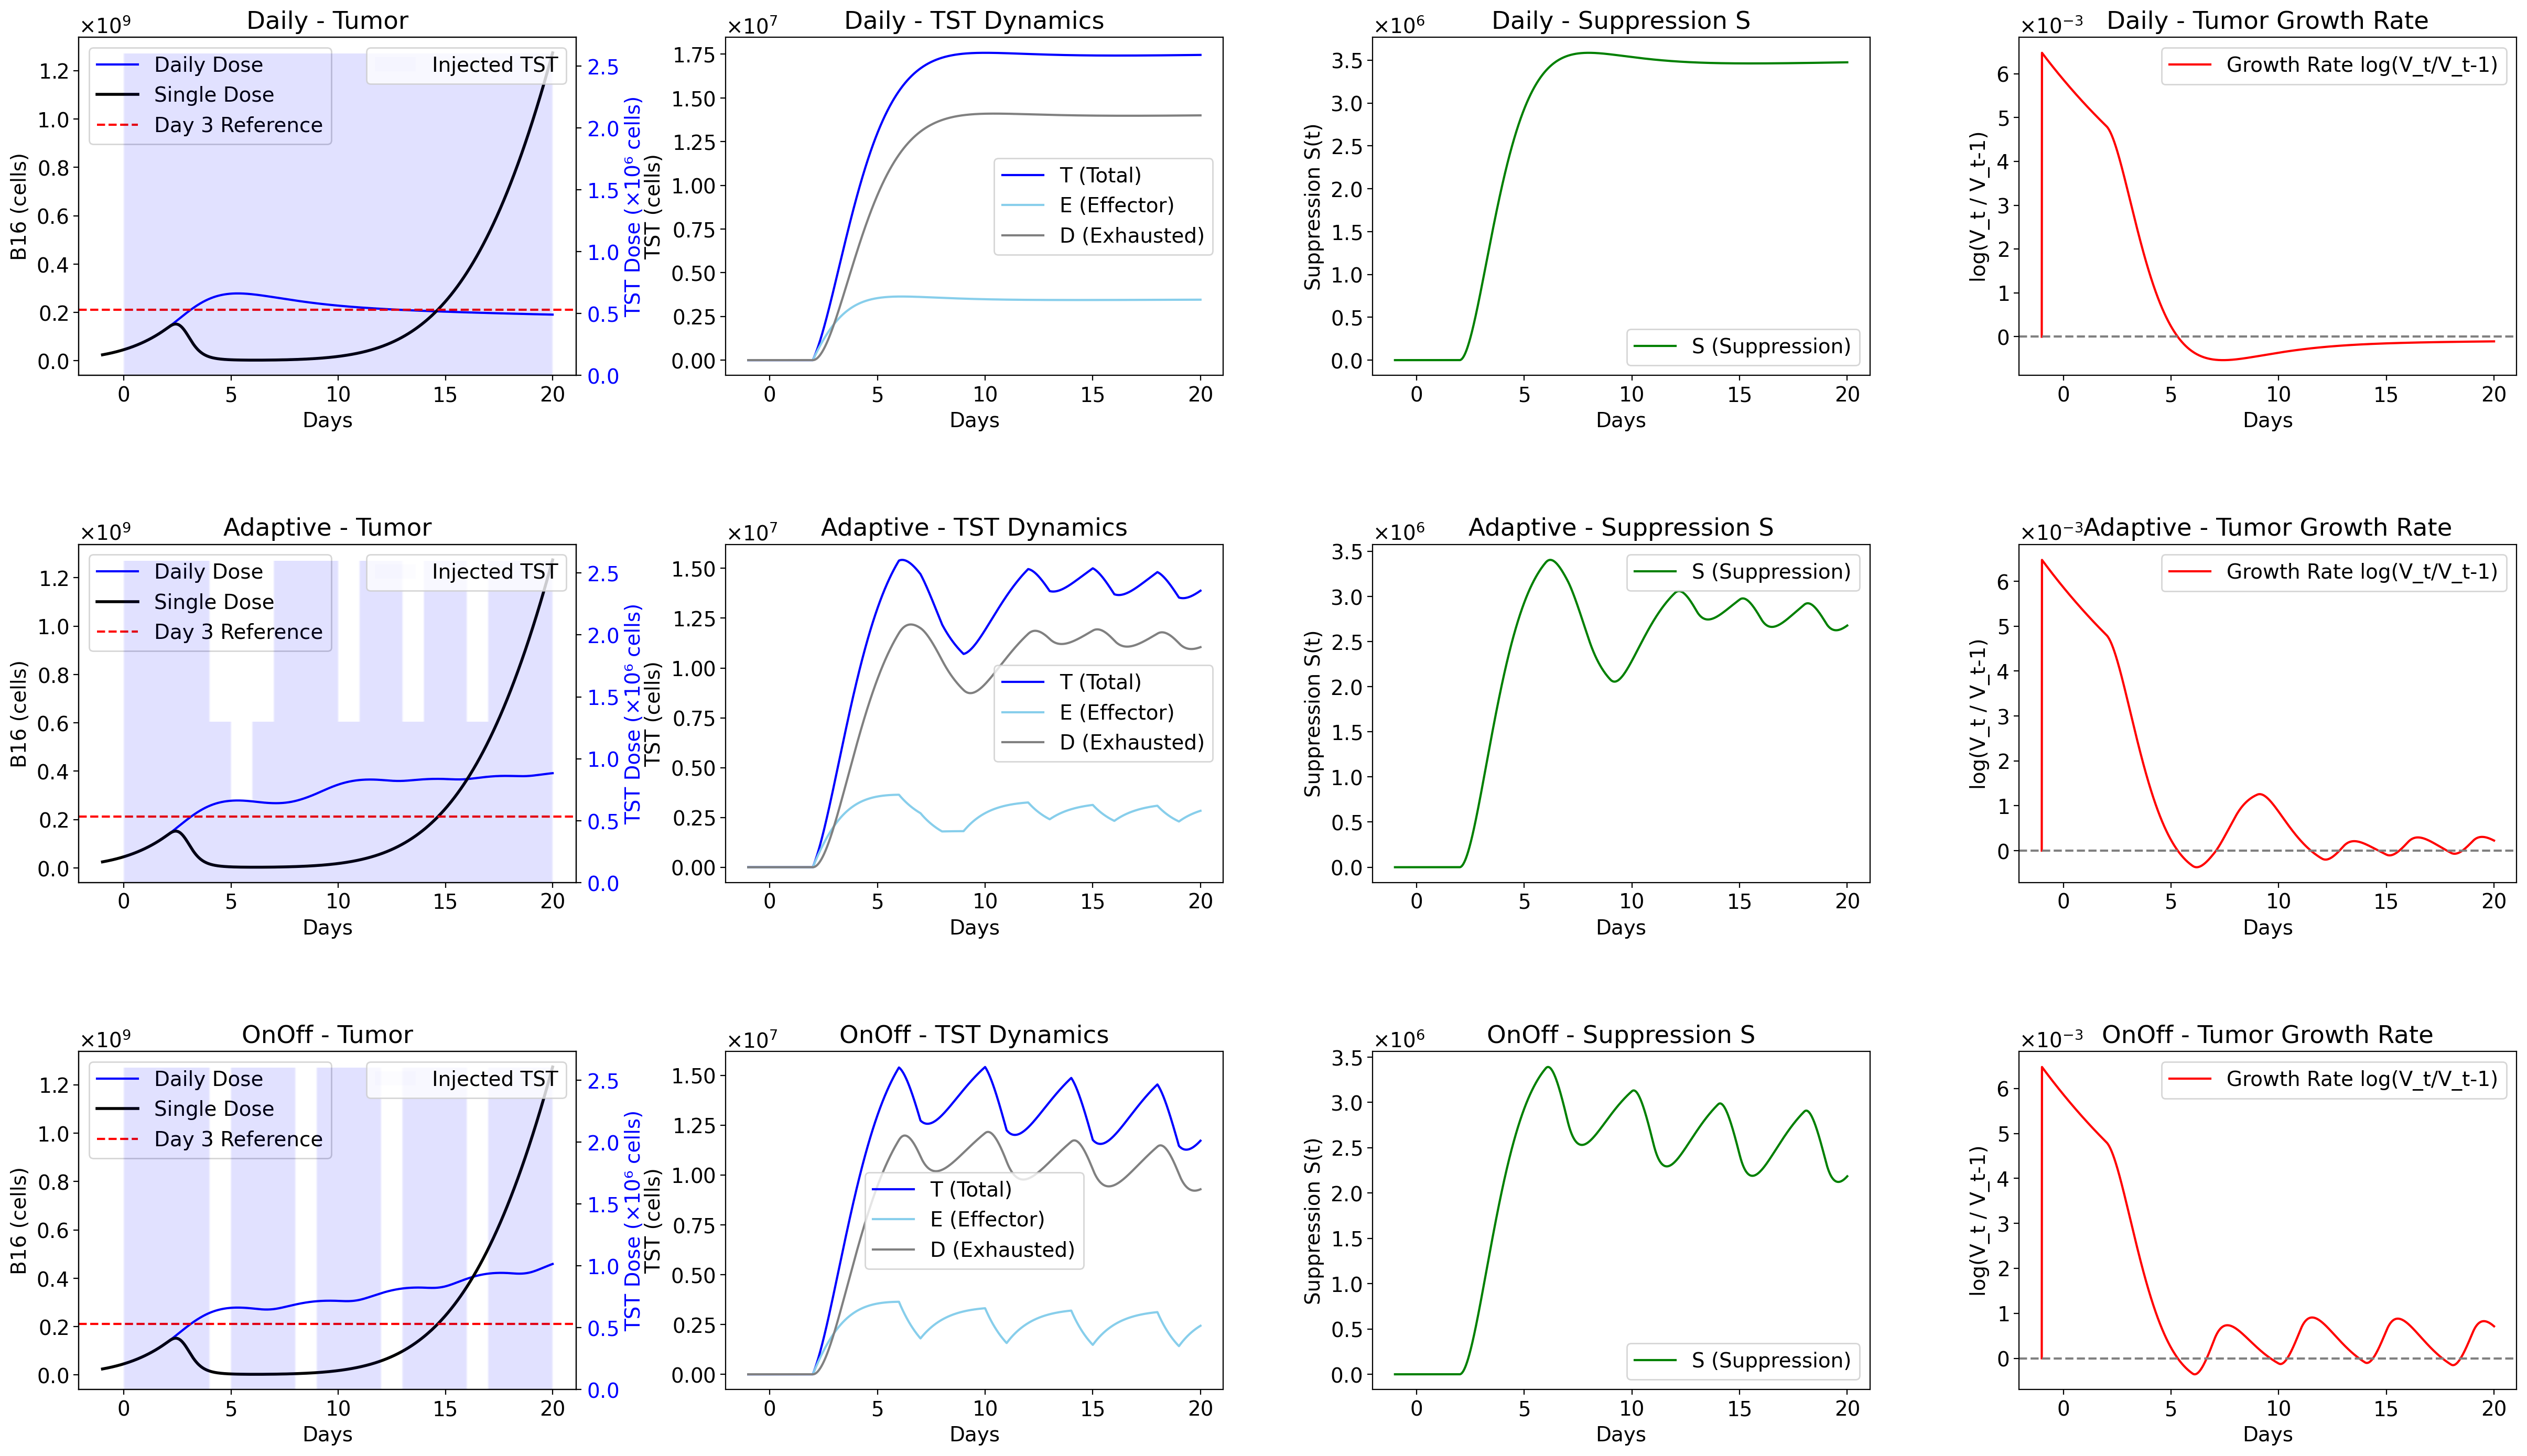

In [21]:
fig = plt.figure(figsize=(25, 15), dpi=200)
plt.rcParams["font.size"] = 14
gs = gridspec.GridSpec(len(results), 4, hspace=0.5, wspace=0.3)

for idx, (strategy, data) in enumerate(results.items()):
    sol = data["solution"]
    V_sol, E_sol, D_sol, S_sol = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]
    T_sol = E_sol + D_sol  # total CTLs

    # CTL dosing schedule (plotted directly, without t_start shift)
    doses_plot = np.zeros_like(t_eval)
    for d, day in data["schedule"]:
        mask = (t_eval >= day) & (t_eval < day + delta_t)
        doses_plot[mask] = d

    # Tumor growth rate: log(V_t / V_{t-1})
    growth_rate = np.zeros_like(t_eval)
    for i in range(1, len(t_eval)):
        if V_sol[i - 1] > 0:
            growth_rate[i] = np.log(V_sol[i] / V_sol[i - 1])

    # === Column 0: Tumor volume with CTL dosing overlay (dual axis) ===
    ax0 = fig.add_subplot(gs[idx, 0])
    ax0.plot(t_eval, V_sol, label='Daily Dose', color='blue')
    ax0.plot(t_eval, V_sol2, label='Single Dose', linewidth=2, color='black')
    ax0.axhline(V_ref, color='red', linestyle='--', label='Day 3 Reference')
    ax0.set_xlabel("Days")
    ax0.set_ylabel("B16 (cells)", color='black')
    ax0.tick_params(axis='y', labelcolor='black')
    set_scientific_yticks(ax0)

    # Show CTL dose as bar plot (secondary y-axis)
    ax0b = ax0.twinx()
    ax0b.bar(t_eval, doses_plot / 1e6, width=0.1, color='blue', alpha=0.01, label='Injected TST')
    ax0b.set_ylabel("TST Dose (×10⁶ cells)", color='blue')
    ax0b.tick_params(axis='y', labelcolor='blue')
    set_scientific_yticks(ax0b)
    ax0.set_title(f"{strategy} - Tumor")
    ax0.legend(loc='upper left')
    ax0b.legend(loc='upper right')

    # === Column 1: CTL dynamics ===
    ax1 = fig.add_subplot(gs[idx, 1])
    ax1.plot(t_eval, T_sol, label='T (Total)', color='blue')
    ax1.plot(t_eval, E_sol, label='E (Effector)', color='skyblue')
    ax1.plot(t_eval, D_sol, label='D (Exhausted)', color='gray')
    ax1.set_title(f"{strategy} - TST Dynamics")
    ax1.set_xlabel("Days")
    ax1.set_ylabel("TST (cells)")
    ax1.legend()
    set_scientific_yticks(ax1)

    # === Column 2: Suppression signal S ===
    ax2 = fig.add_subplot(gs[idx, 2])
    ax2.plot(t_eval, S_sol, label='S (Suppression)', color='green')
    ax2.set_title(f"{strategy} - Suppression S")
    ax2.set_xlabel("Days")
    ax2.set_ylabel("Suppression S(t)")
    ax2.legend()
    set_scientific_yticks(ax2)

    # === Column 3: Tumor growth rate ===
    ax3 = fig.add_subplot(gs[idx, 3])
    ax3.plot(t_eval, growth_rate, label='Growth Rate log(V_t/V_t-1)', color='red')
    ax3.axhline(0, linestyle='--', color='gray')
    ax3.set_title(f"{strategy} - Tumor Growth Rate")
    ax3.set_xlabel("Days")
    ax3.set_ylabel("log(V_t / V_t-1)")
    ax3.legend()
    set_scientific_yticks(ax3)

plt.subplots_adjust(left=0.05, right=0.98, top=0.93, bottom=0.07, wspace=0.3, hspace=0.5)
plt.show()


# Max x2

In [22]:
daily_20_2 = (min_ctl_20/20)*2

In [23]:
#days = list(range(0, 8))  # Day0 to Day20
days = list(range(0, 20))
t_eval = np.arange(-1, 20.01, 0.01)
D_list2 = np.array([0, daily_20_2/4, daily_20_2/2, daily_20_2])
maxD = max(D_list2)

strategies = ["Daily", "Adaptive", "OnOff"]
results2 = {}

for strategy in strategies:
    sched = generate_schedule_maxD(strategy, maxD, D_list2)
    sol = odeint(ode_with_schedule, y0, t_eval, args=(sched, delta_t, param), hmax=0.01)
    V_day20 = sol[np.where(np.abs(t_eval - 20) < 1e-5)[0][0], 0]
    total_ctl = sum(d for d, _ in sched)
    results2[strategy] = {"V20": V_day20, "CTL_total": total_ctl, "solution": sol, "schedule": sched}

results2

{'Daily': {'V20': 6755418.060536476,
  'CTL_total': 104000000.0,
  'solution': array([[24982352.94117647,        0.        ,        0.        ,
                 0.        ,  1527494.82596666],
         [25144692.67354849,        0.        ,        0.        ,
                 0.        ,  1535015.11610721],
         [25307923.57139263,        0.        ,        0.        ,
                 0.        ,  1542591.5805303 ],
         ...,
         [ 6769260.90341362,  6688863.62087794, 27352729.10314671,
           6722613.5685427 , 83166552.30190204],
         [ 6762332.77698256,  6688920.86408083, 27352944.70009691,
           6722680.05392694, 83164056.61386423],
         [ 6755418.06053648,  6688978.02130744, 27353160.05807281,
           6722746.45089463, 83161565.18538211]]),
  'schedule': [(5200000.0, 0),
   (5200000.0, 1),
   (5200000.0, 2),
   (5200000.0, 3),
   (5200000.0, 4),
   (5200000.0, 5),
   (5200000.0, 6),
   (5200000.0, 7),
   (5200000.0, 8),
   (5200000.0, 9),
   (52000

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.1305112906915D-15


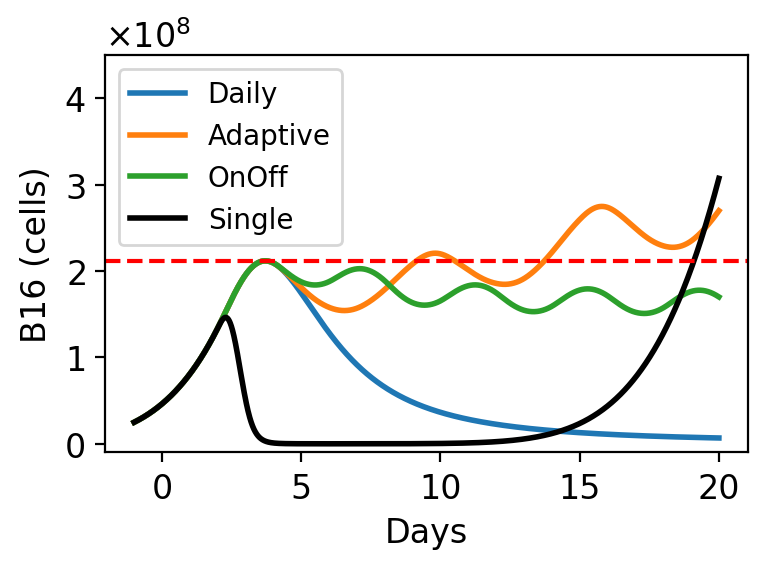

In [24]:
# === Comparison with Single-Dose Strategy ===
plt.rcParams.update({'font.size': 12})

# Initial conditions: 
# V = tumor volume, E = effector CTLs, D = exhausted CTLs, S = suppression signal
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]  # y = [V, E, D, S, M]

# Time axis for simulation
t_eval = np.arange(-1, 20.01, 0.01)

# CTL dosing schedule for single high-dose administration
dose_list = [daily_20_2 * 20]  # total dose as a single pulse
dose_days = [0]              # administration on day 0
delta_t = 1                  # duration of administration (in days)

# Solve ODE
sol2 = odeint(model, y0, t_eval, 
              args=(dose_list, dose_days, delta_t, param),
              hmax=0.001)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2 + D_sol2  # total CTLs

# === Time-Course Plot of Tumor Volume ===
plt.figure(figsize=(4, 3), dpi=200)

for strategy, data in results2.items():
    V_sol = data["solution"][:, 0]
    plt.plot(t_eval, V_sol, label=strategy, linewidth=2)

# Plot single-dose result for comparison
plt.plot(t_eval, V_sol2, label='Single', linewidth=2, color='black')

# Reference line (e.g., Day 3 tumor size)
plt.axhline(V_ref, color='red', linestyle='--')

plt.xlabel("Days")
plt.ylabel("B16 (cells)")
plt.ylim([-1e7, 4.5e8])
#plt.title("Comparison of Dosing Strategies")
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()

ax = plt.gca()
set_scientific_yticks(ax)


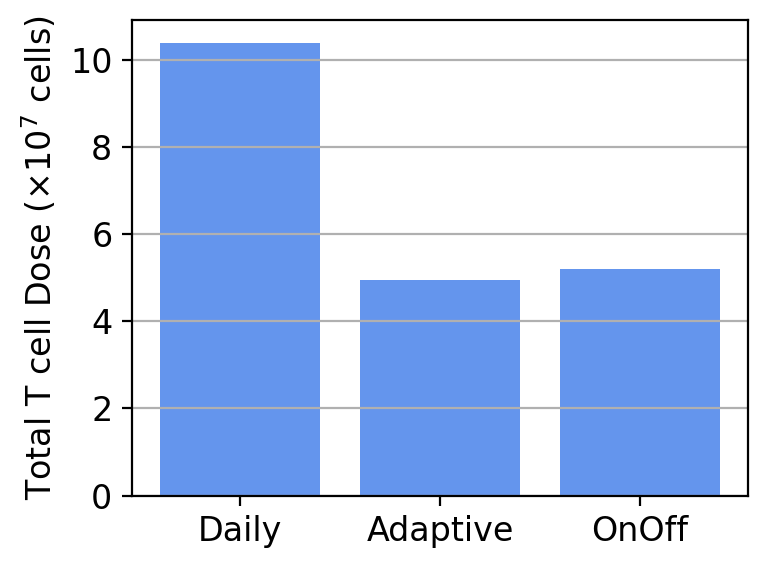

In [25]:
# Visualize total CTL dose for each strategy as a bar graph
strategies2 = list(results2.keys())
# Convert units to 10^7 cells for readability
total_doses = [results2[strategy]["CTL_total"] / 1e7 for strategy in strategies2]

plt.figure(figsize=(4, 3), dpi=200)
bars = plt.bar(strategies, total_doses, color='cornflowerblue')
plt.ylabel(r"Total T cell Dose ($\times 10^7$ cells)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

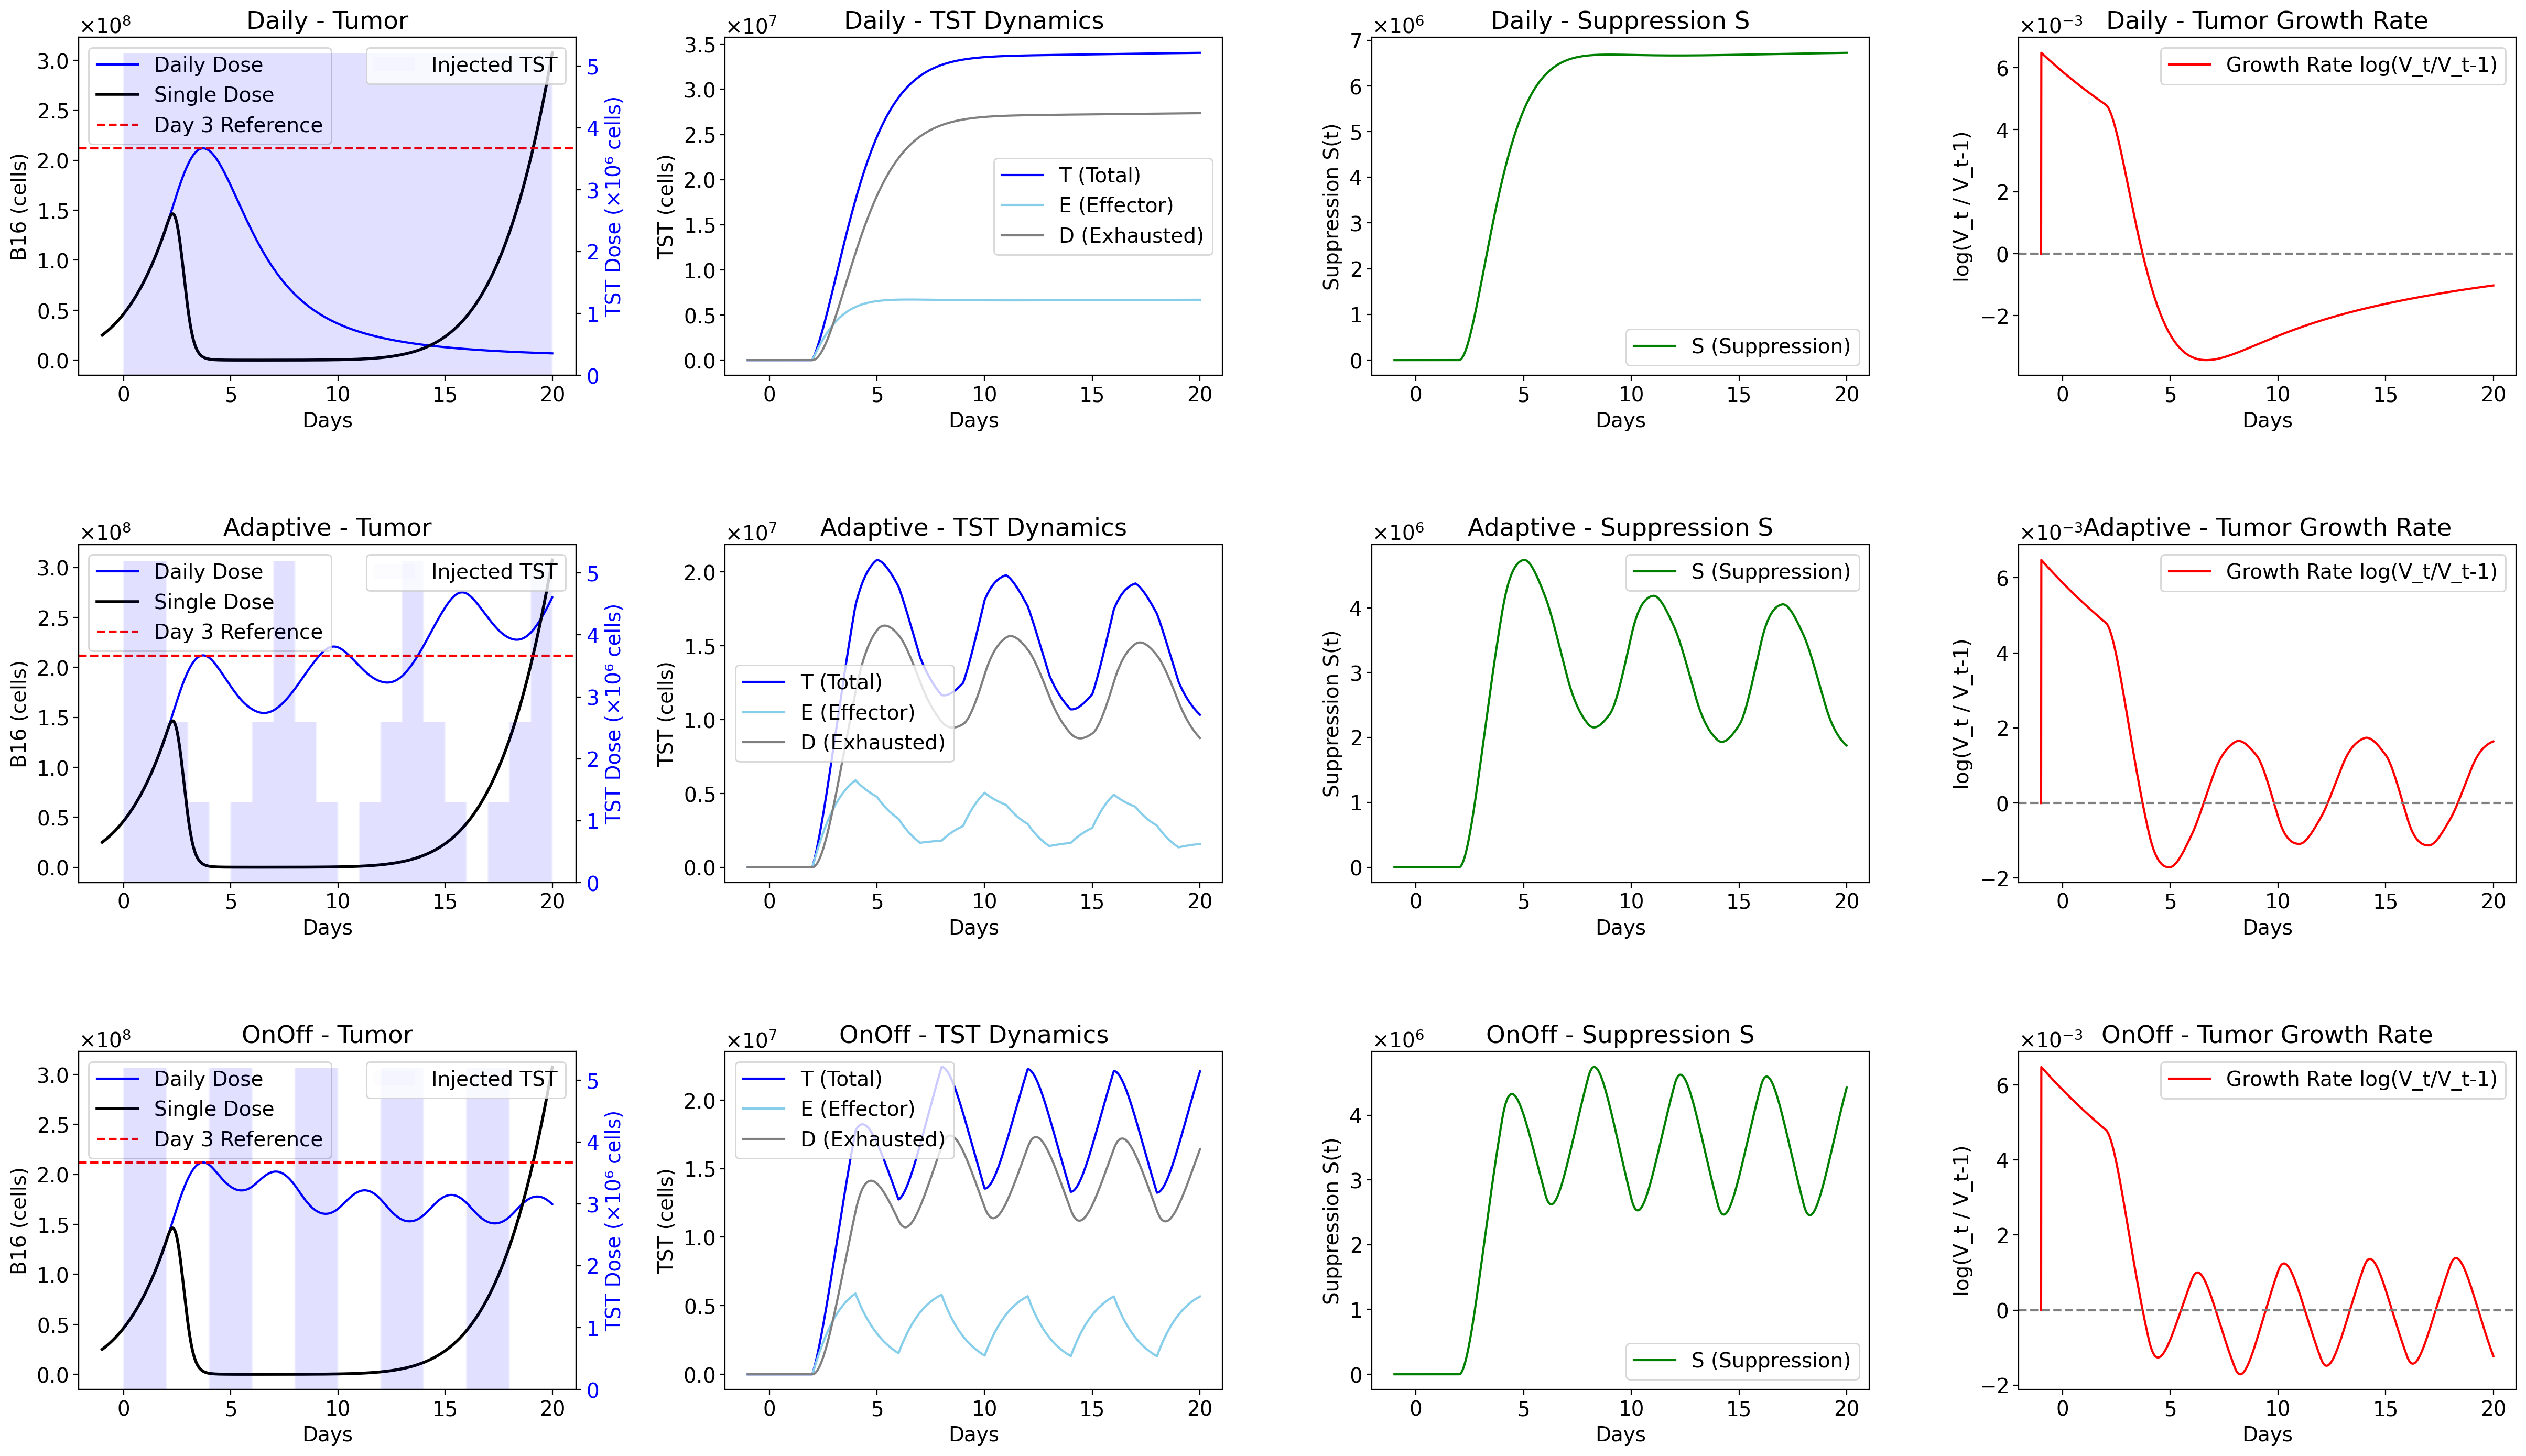

In [26]:
fig = plt.figure(figsize=(25, 15), dpi=200)
plt.rcParams["font.size"] = 14
gs = gridspec.GridSpec(len(results), 4, hspace=0.5, wspace=0.3)

for idx, (strategy, data) in enumerate(results2.items()):
    sol = data["solution"]
    V_sol, E_sol, D_sol, S_sol = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]
    T_sol = E_sol + D_sol  # total CTLs

    # CTL dosing schedule (plotted directly, without t_start shift)
    doses_plot = np.zeros_like(t_eval)
    for d, day in data["schedule"]:
        mask = (t_eval >= day) & (t_eval < day + delta_t)
        doses_plot[mask] = d

    # Tumor growth rate: log(V_t / V_{t-1})
    growth_rate = np.zeros_like(t_eval)
    for i in range(1, len(t_eval)):
        if V_sol[i - 1] > 0:
            growth_rate[i] = np.log(V_sol[i] / V_sol[i - 1])

    # === Column 0: Tumor volume with CTL dosing overlay (dual axis) ===
    ax0 = fig.add_subplot(gs[idx, 0])
    ax0.plot(t_eval, V_sol, label='Daily Dose', color='blue')
    ax0.plot(t_eval, V_sol2, label='Single Dose', linewidth=2, color='black')
    ax0.axhline(V_ref, color='red', linestyle='--', label='Day 3 Reference')
    ax0.set_xlabel("Days")
    ax0.set_ylabel("B16 (cells)", color='black')
    ax0.tick_params(axis='y', labelcolor='black')
    set_scientific_yticks(ax0)

    # Show CTL dose as bar plot (secondary y-axis)
    ax0b = ax0.twinx()
    ax0b.bar(t_eval, doses_plot / 1e6, width=0.1, color='blue', alpha=0.01, label='Injected TST')
    ax0b.set_ylabel("TST Dose (×10⁶ cells)", color='blue')
    ax0b.tick_params(axis='y', labelcolor='blue')
    set_scientific_yticks(ax0b)
    ax0.set_title(f"{strategy} - Tumor")
    ax0.legend(loc='upper left')
    ax0b.legend(loc='upper right')

    # === Column 1: CTL dynamics ===
    ax1 = fig.add_subplot(gs[idx, 1])
    ax1.plot(t_eval, T_sol, label='T (Total)', color='blue')
    ax1.plot(t_eval, E_sol, label='E (Effector)', color='skyblue')
    ax1.plot(t_eval, D_sol, label='D (Exhausted)', color='gray')
    ax1.set_title(f"{strategy} - TST Dynamics")
    ax1.set_xlabel("Days")
    ax1.set_ylabel("TST (cells)")
    ax1.legend()
    set_scientific_yticks(ax1)

    # === Column 2: Suppression signal S ===
    ax2 = fig.add_subplot(gs[idx, 2])
    ax2.plot(t_eval, S_sol, label='S (Suppression)', color='green')
    ax2.set_title(f"{strategy} - Suppression S")
    ax2.set_xlabel("Days")
    ax2.set_ylabel("Suppression S(t)")
    ax2.legend()
    set_scientific_yticks(ax2)

    # === Column 3: Tumor growth rate ===
    ax3 = fig.add_subplot(gs[idx, 3])
    ax3.plot(t_eval, growth_rate, label='Growth Rate log(V_t/V_t-1)', color='red')
    ax3.axhline(0, linestyle='--', color='gray')
    ax3.set_title(f"{strategy} - Tumor Growth Rate")
    ax3.set_xlabel("Days")
    ax3.set_ylabel("log(V_t / V_t-1)")
    ax3.legend()
    set_scientific_yticks(ax3)

plt.subplots_adjust(left=0.05, right=0.98, top=0.93, bottom=0.07, wspace=0.3, hspace=0.5)
plt.show()
